<a href="https://colab.research.google.com/github/iannwtf19/iannwtf19/blob/main/Week9/Homework9_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import urllib
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import tqdm

# Generating the Dataset

First we download the Quick! Draw! images & generate a tensorflow dataset from it.

In [2]:
def load_dataset(category):
    if not os.path.isdir('npy_files'):
        os.mkdir('npy_files')

    url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'
    filename = f'npy_files/{category}.npy'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)

    images = np.load(filename)

    # Assign 60000 images to training & 10000 to test datasets
    train_images = images[:60000]
    test_images = images[60000:70000]

    train_ds = tf.data.Dataset.from_tensor_slices(train_images)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images)

    return train_ds, test_ds

Then we preprocess this dataset as usual to fit our needs.

In [3]:
def preprocess(ds, batch_size):
    # cast & normalize image data to between -1 and 1
    ds = ds.map(lambda img: tf.cast(img, tf.float32) / 128. - 1.)
    # reshape the (1, 784) vector into (28, 28, 1)
    ds = ds.map(lambda img: tf.reshape(img, [28, 28, 1]))

    return ds.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
train_ds, test_ds = load_dataset('candle')
batch_size = 32
train_ds = preprocess(train_ds, batch_size)
test_ds = preprocess(test_ds, batch_size)

Let's show a few example images

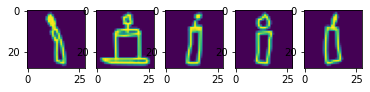

In [5]:
for img in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(tf.squeeze(img[i]))


# Discriminator model

Our discriminator model will use convolutional layers to extract features, and a dense layer to output a single number between 0 and 1 to indicate whether the image is real or not.

In [6]:
class Discriminator(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.layer_list = [
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, padding='same',
                                   input_shape=(28, 28,1)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),            
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]

    def call(self, x, training=None, mask=None):
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x

# Generator model

Now let's define the generator model.

In [7]:
class Generator(tf.keras.Model):
    def __init__(self, latent_space_size):
        super().__init__()
        self.latent_space_size = latent_space_size
        self.layer_list = [
            tf.keras.layers.Dense(7 * 7, activation='relu', input_shape=(latent_space_size,)),
            tf.keras.layers.Reshape(target_shape=(7, 7, 1)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),       
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),            
            tf.keras.layers.Conv2D(filters=1, kernel_size=4, activation='tanh', strides=1, padding='same')
        ]

    def call(self, x, training=None, mask=None):
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x

## GAN model

In [8]:
class GAN(tf.keras.Model):

    def __init__(self, latent_space_size, generator_optimiser, discriminator_optimiser):
        super().__init__()
        self.latent_space_size = latent_space_size

        self.discriminator = Discriminator()
        self.discriminator_optimizer = discriminator_optimiser

        self.generator = Generator(latent_space_size)
        self.generator_optimizer = generator_optimiser

        self.discriminator_loss = tf.keras.losses.BinaryCrossentropy()
        self.generator_loss = tf.keras.losses.BinaryCrossentropy()

        self.metrics_list = [
            tf.keras.metrics.Mean(name="disc_loss"),
            tf.keras.metrics.Mean(name="gen_loss")
        ]

    @tf.function
    def call(self, x, training=False):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_space_size])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(tf.ones_like(fake_output), fake_output)
            disc_loss = self.calculate_discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        self.metrics[0].update_state(disc_loss)
        self.metrics[1].update_state(gen_loss)

        return {m.name: m.result() for m in self.metrics}

    cross_entropy = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def calculate_discriminator_loss(self, real_output, fake_output):
        real_loss = self.discriminator_loss(tf.ones_like(real_output), real_output)
        fake_loss = self.discriminator_loss(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

Generate one image from random noise and see what happens

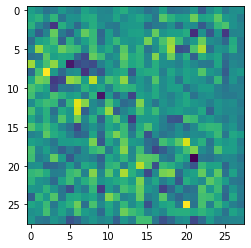

In [9]:
latent_space_size = 100
gan = GAN(latent_space_size, tf.keras.optimizers.Adam(0.0005), tf.keras.optimizers.Adam(0.0005))
noise = tf.random.normal([1, latent_space_size])
generated_image = gan.generator(noise, training=False)

plt.imshow(tf.squeeze(generated_image))

Let's try out the discriminator to see what it thinks of this "image"

In [10]:
realness = gan.discriminator(generated_image)
print(realness)

tf.Tensor([[0.49980137]], shape=(1, 1), dtype=float32)


## Training loop

In [11]:
def generate_and_save_images(model, epoch, n):
    noise = tf.random.normal([n, 100])
    predictions = model(noise, training=False)

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(tf.squeeze(predictions[i]))

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [12]:
def training_loop(model, train_ds, num_epochs):
    for epoch in range(num_epochs):
        model.reset_metrics()

        # Loop over all batches of training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        print(
            f'- Epoch {epoch + 1} - '
            f'Discriminator Loss: {model.metrics[0].result()}, '
            f'Generator Loss: {model.metrics[1].result()}'
        )
        # Generate some images during training
        generate_and_save_images(model.generator, epoch + 1, 5)

    # Generate images again at the end of training
    generate_and_save_images(model.generator, num_epochs, 5)

100%|██████████| 1875/1875 [00:20<00:00, 90.02it/s] 


- Epoch 1 - Discriminator Loss: 1.170506477355957, Generator Loss: 36.30952835083008


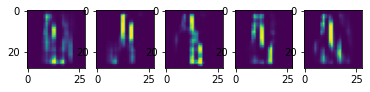

100%|██████████| 1875/1875 [00:17<00:00, 104.32it/s]


- Epoch 2 - Discriminator Loss: 0.2742694318294525, Generator Loss: 26.987585067749023


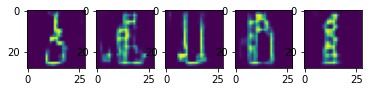

100%|██████████| 1875/1875 [00:18<00:00, 101.59it/s]


- Epoch 3 - Discriminator Loss: 0.24425062537193298, Generator Loss: 27.78499984741211


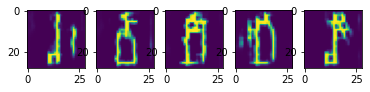

100%|██████████| 1875/1875 [00:18<00:00, 103.73it/s]


- Epoch 4 - Discriminator Loss: 0.1917753368616104, Generator Loss: 28.979162216186523


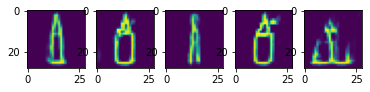

100%|██████████| 1875/1875 [00:18<00:00, 103.59it/s]


- Epoch 5 - Discriminator Loss: 0.17926134169101715, Generator Loss: 30.269344329833984


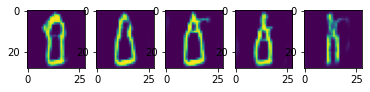

100%|██████████| 1875/1875 [00:18<00:00, 103.43it/s]


- Epoch 6 - Discriminator Loss: 0.17244049906730652, Generator Loss: 27.97478485107422


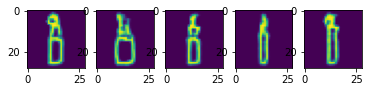

100%|██████████| 1875/1875 [00:18<00:00, 103.69it/s]


- Epoch 7 - Discriminator Loss: 0.44527575373649597, Generator Loss: 39.27714538574219


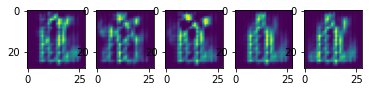

100%|██████████| 1875/1875 [00:18<00:00, 103.93it/s]


- Epoch 8 - Discriminator Loss: 0.11845683306455612, Generator Loss: 46.64714431762695


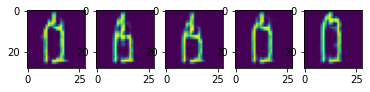

100%|██████████| 1875/1875 [00:18<00:00, 104.10it/s]


- Epoch 9 - Discriminator Loss: 0.05550108477473259, Generator Loss: 50.69645309448242


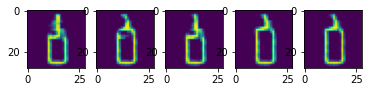

100%|██████████| 1875/1875 [00:18<00:00, 104.08it/s]


- Epoch 10 - Discriminator Loss: 0.07700168341398239, Generator Loss: 48.583560943603516


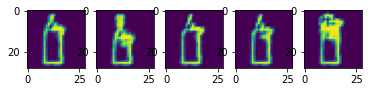

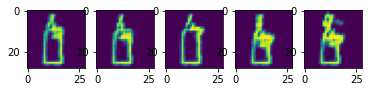

In [13]:
num_epochs = 10
training_loop(gan, train_ds, num_epochs)